<a href="https://colab.research.google.com/github/imshiv-10/Deep-Learning/blob/main/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working with Images

In this tutorial, we'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: *image classification*. We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We begin by installing and importing torch and torchvision. torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
dataset = MNIST(root='./data', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



en this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch Dataset. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [6]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [7]:
test_dataset = MNIST(root='./data', train=False)

In [8]:
len(test_dataset)

10000

In [9]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F6701D91850>, 5)

In [10]:
from PIL.Image import Image

In [14]:
Image.show(dataset[0][0]), dataset[0][1]

(None, 5)

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

label :  5


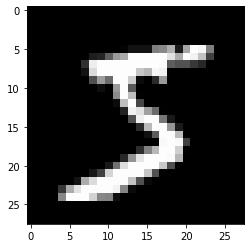

In [24]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('label : ',label)

In [25]:
len(dataset)

60000

label:  9


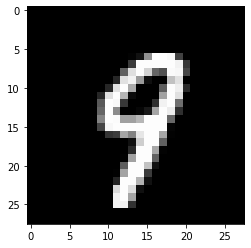

In [26]:
image, label = dataset[389]
plt.imshow(image, cmap='gray')
print('label: ', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [27]:
from torchvision.transforms import transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The torchvision.transforms module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [28]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

AttributeError: ignored

In [34]:
dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor())

In [35]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [45]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

In [43]:
img_tensor.shape

torch.Size([1, 28, 28])

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])


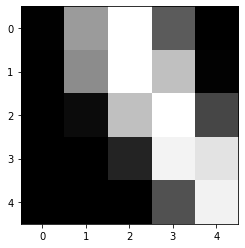

In [48]:
print(img_tensor[0, 10:15,10:15])
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.
In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.
Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [49]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset=dataset, lengths=[50000,10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [61]:
def ImgShow(dataset):
  img_tensor, label = dataset
  plt.imshow(img_tensor[0,:,:], cmap='gray')
  print('Label: ', label)

Label:  5


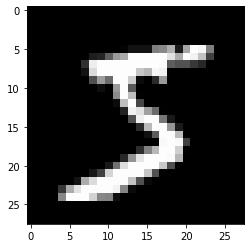

In [62]:
ImgShow(dataset[0])

Label:  4


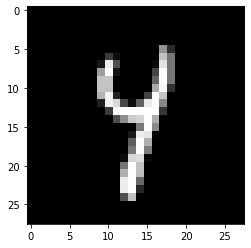

In [63]:
ImgShow(train_ds[0])

Label:  0


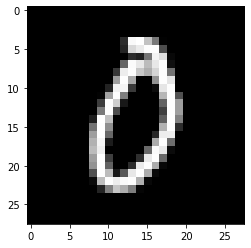

In [64]:
ImgShow(val_ds[0])

Label:  2
Label:  8
Label:  3
Label:  3
Label:  8
Label:  0
Label:  1
Label:  8
Label:  6
Label:  1


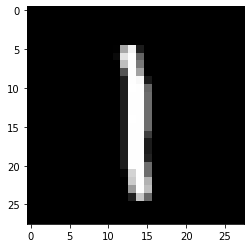

In [75]:
import numpy as np
for img in np.random.randint(100, size=10):
  ImgShow(dataset[img])

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.
We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [77]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 128 ## 50000/128 - around 390 images per batch
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle=True)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.